# Stochastic Variation Inference with Auto Guide Generation of an Emission Spectrum Using NumPyro 

Last update: Febrary 3rd (2025) Hajime Kawahara for v2.0

In this guide, we perform retrieval of an emission spectrum using [stochastic variational inference (SVI)](https://num.pyro.ai/en/latest/svi.html) with automatic guide generation. The structure is the same as in the [getting started](get_started.html) guide, except that we use SVI instead of HMC-NUTS; i.e. we will use ExoJAX to simulate a high-resolution emission spectrum from an atmosphere with CO molecular absorption and hydrogen molecule CIA continuum absorption as the opacity sources. We will then add appropriate noise to the simulated spectrum to create a mock spectrum and perform spectral retrieval using the nested sampling. 


Here, we use SVI and ..., which is bundled with NumPyro, as the sampler. Notably, apart from the final retrieval step, most of the code remains the same as in the HMC-NUTS case.


First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [1]:
from jax import config
config.update("jax_enable_x64", True)

The following schematic figure explains how ExoJAX works; 
(1) loading databases (`*db`), 
(2) calculating opacity (`opa`),
(3) running atmospheric radiative transfer (`art`),
(4) applying operations on the spectrum (`sop`)

In this guide, there are two opacity sources, CO and CIA. Their respective databases, `mdb` and `cdb`, are converted by `opa` into the opacity of each atmospheric layer, which is then used in the radiative transfer calculation performed by `art`. Finally, `sop` convolves the rotational effects and instrumental profiles, generating the emission spectrum. 

`mdb`/`cdb` --> `opa` --> `art` --> `sop` ---> spectrum

This spectral model is incorporated into the probabilistic model in NumPyro with JAXNS, and retrieval is performed by sampling using nested sampling.




![Figure. Structure of ExoJAX](https://secondearths.sakura.ne.jp/exojax/figures/exojax_svi.png)


## 1. Loading a molecular database using mdb

ExoJAX has an API for molecular databases, called `mdb` (or `adb` for atomic datbases). Prior to loading the database, define the wavenumber range first.

In [2]:
from exojax.utils.grids import wavenumber_grid

nu_grid, wav, resolution = wavenumber_grid(
    22920.0, 23000.0, 3500, unit="AA", xsmode="premodit"
)
print("Resolution=", resolution)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
Resolution= 1004211.9840291934


/home/kawahara/exojax/src/exojax/utils.grids.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


Then, let's load the molecular database. We here use Carbon monoxide in Exomol. `CO/12C-16O/Li2015` means `Carbon monoxide/ isotopes = 12C + 16O / database name`. You can check the database name in the ExoMol website (https://www.exomol.com/).  

In [3]:
from exojax.database.api  import MdbExomol
mdb = MdbExomol(".database/CO/12C-16O/Li2015", nurange=nu_grid)

/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


HITRAN exact name= (12C)(16O)
radis engine =  vaex
Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(


## 2. Computation of the Cross Section using opa

ExoJAX has various opacity calculator classes, so-called `opa`. Here, we use a memory-saved opa, `OpaPremodit`. We assume the robust tempreature range we will use is 500-1500K.

In [4]:
from exojax.opacity.opacalc import OpaPremodit
opa = OpaPremodit(mdb, nu_grid, auto_trange=[500.0, 1500.0], dit_grid_resolution=1.0)

OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K


/home/kawahara/exojax/src/exojax/spec/opacalc.py:215: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]

Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%


Then let's compute cross section for two different temperature 500 and 1500 K for P=1.0 bar. opa.xsvector can do that!

In [5]:
P = 1.0  # bar
T_1 = 500.0  # K
xsv_1 = opa.xsvector(T_1, P)  # cm2

T_2 = 1500.0  # K
xsv_2 = opa.xsvector(T_2, P)  # cm2

Plot them. It can be seen that different lines are stronger at different temperatures.

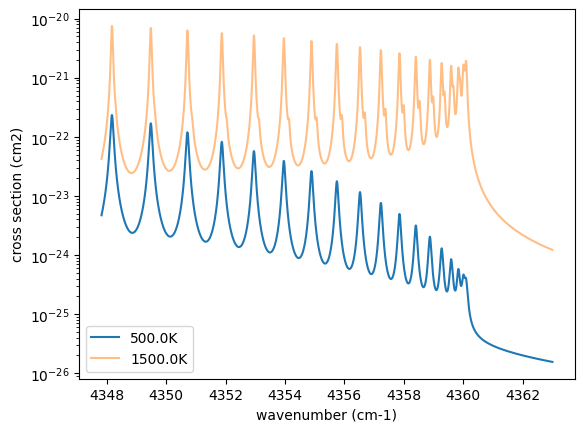

In [6]:
import matplotlib.pyplot as plt

plt.plot(nu_grid, xsv_1, label=str(T_1) + "K")  # cm2
plt.plot(nu_grid, xsv_2, alpha=0.5, label=str(T_2) + "K")  # cm2
plt.yscale("log")
plt.legend()
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

## 3. Atmospheric Radiative Transfer

ExoJAX can solve the radiative transfer and derive the emission spectrum. To do so, ExoJAX has `art` class. `ArtEmisPure` means Atomospheric Radiative Transfer for Emission with Pure absorption. So, `ArtEmisPure` does not include scattering.
We set the number of the atmospheric layer to 200 (nlayer) and the pressure at bottom and top atmosphere to 100 and 1.e-5 bar.

Since v1.5, one can choose the rtsolver (radiative transfer solver) from the flux-based 2 stream solver (`fbase2st`) and the intensity-based n-stream sovler (`ibased`). Use `rtsolver` option. In the latter case, the number of the stream (`nstream`) can be specified. Note that the default rtsolver for the pure absorption (i.e. no scattering nor reflection) has been `ibased` since v1.5.
In our experience, `ibased` is faster and more accurate than `fbased`.

In [7]:
from exojax.rt.atmrt import ArtEmisPure

art = ArtEmisPure(
    nu_grid=nu_grid,
    pressure_btm=1.0e1,
    pressure_top=1.0e-5,
    nlayer=100,
    rtsolver="ibased",
    nstream=8,
)

rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Let's assume the power law temperature model, within 500 - 1500 K.

$T = T_0 P^\alpha$

where $T_0=1200$ K and $\alpha=0.1$.

In [8]:
art.change_temperature_range(500.0, 1500.0)
Tarr = art.powerlaw_temperature(1200.0, 0.1)

Also, the mass mixing ratio of CO (MMR) should be defined.

In [9]:
mmr_profile = art.constant_mmr_profile(0.01)

Surface gravity is also important quantity of the atmospheric model, which is a function of planetary radius and mass. Here we assume 1 RJ and 10 MJ.

In [10]:
from exojax.utils.astrofunc import gravity_jupiter

gravity = gravity_jupiter(1.0, 10.0)

In addition to the CO cross section, we would consider [collisional induced absorption](https://en.wikipedia.org/wiki/Collision-induced_absorption_and_emission) (CIA) as a continuum opacity. `cdb` class can be used.

In [11]:
from exojax.database.contdb  import CdbCIA
from exojax.opacity.opacont import OpaCIA

cdb = CdbCIA(".database/H2-H2_2011.cia", nurange=nu_grid)
opacia = OpaCIA(cdb, nu_grid=nu_grid)

H2-H2


Before running the radiative transfer, we need cross sections for layers, called `xsmatrix` for CO and `logacia_matrix` for CIA (strictly speaking, the latter is not cross section but coefficient because CIA intensity is proportional density square). See [here](CIA_opacity.html) for the details.

In [12]:
xsmatrix = opa.xsmatrix(Tarr, art.pressure)
logacia_matrix = opacia.logacia_matrix(Tarr)

Convert them to opacity

In [13]:
dtau_CO = art.opacity_profile_xs(xsmatrix, mmr_profile, mdb.molmass, gravity)
vmrH2 = 0.855  # VMR of H2
mmw = 2.33  # mean molecular weight of the atmosphere
dtaucia = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2, mmw, gravity)

Add two opacities.

In [14]:
dtau = dtau_CO + dtaucia

Then, run the radiative transfer.
As you can see, the emission spectrum has been generated. This spectrum shows a region near 4360 cm-1, or around 22940 AA, where CO features become increasingly dense. This region is referred to as the band head. If you're interested in why the band head occurs, please refer to [Quatum states of Carbon Monoxide and Fortrat Diagram](Fortrat.html).


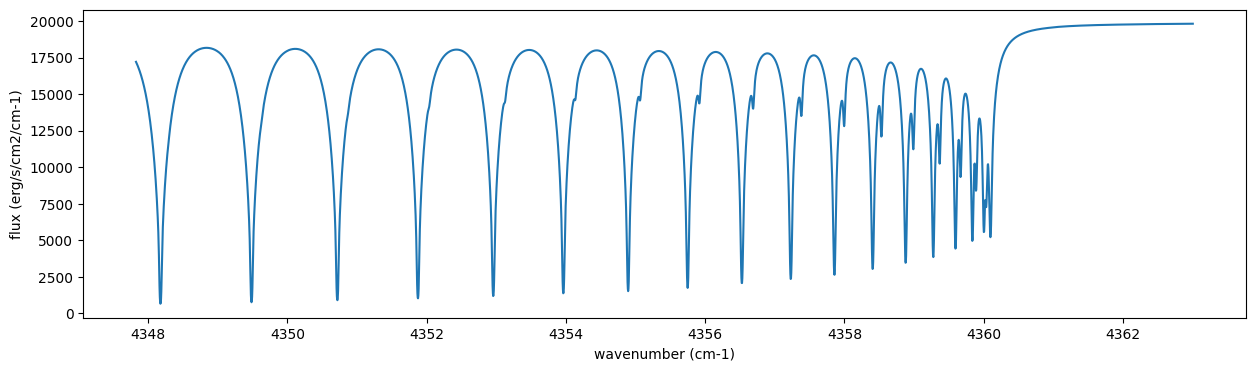

In [15]:
F = art.run(dtau, Tarr)

fig = plt.figure(figsize=(15, 4))
plt.plot(nu_grid, F)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

You can check the contribution function too! 
You should check if the dominant contribution is within the layer. 
If not, you need to change `pressure_top` and `pressure_btm` in `ArtEmisPure`    

In [16]:
from exojax.plot.atmplot import plotcf

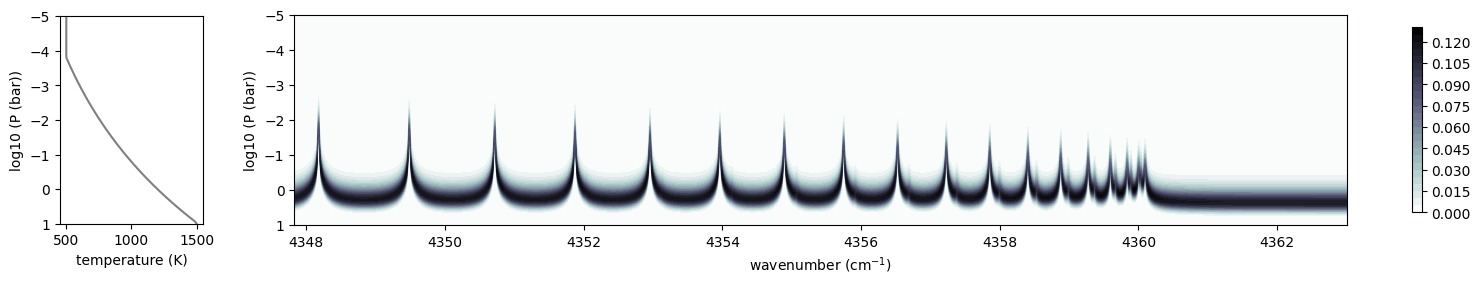

In [17]:
cf = plotcf(nu_grid, dtau, Tarr, art.pressure, art.dParr)

## 4. Spectral Operators: rotational broadening, instrumental profile, Doppler velocity shift and so on, any operation on spectra.

The above spectrum is called "raw spectrum" in ExoJAX. The effects applied to the raw spectrum is handled in ExoJAX by the spectral operator (`sop`).
First, we apply the spin rotational broadening of a planet.

In [18]:
from exojax.postproc.specop import SopRotation

sop_rot = SopRotation(nu_grid, vsini_max=100.0)

vsini = 10.0
u1 = 0.0
u2 = 0.0
Frot = sop_rot.rigid_rotation(F, vsini, u1, u2)

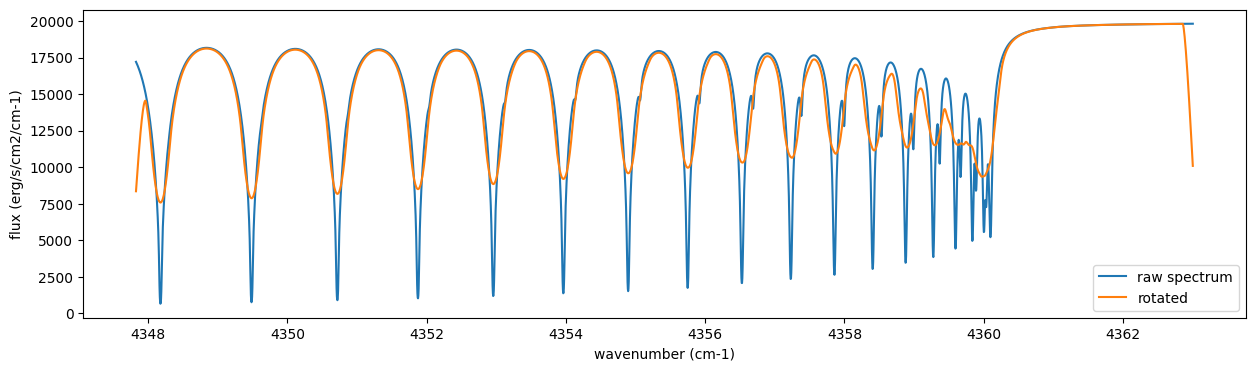

In [19]:
fig = plt.figure(figsize=(15, 4))
plt.plot(nu_grid, F, label="raw spectrum")
plt.plot(nu_grid, Frot, label="rotated")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.legend()
plt.show()

Then, the instrumental profile with relative radial velocity shift is applied. Also, we need to match the computed spectrum to the data grid. This process is called `sampling` (but just interpolation though). Below, let’s perform a simulation that includes noise for use in later analysis.

In [20]:
from exojax.postproc.specop import SopInstProfile
from exojax.utils.instfunc import resolution_to_gaussian_std

sop_inst = SopInstProfile(nu_grid, vrmax=1000.0)

RV = 40.0  # km/s
resolution_inst =70000.0
beta_inst = resolution_to_gaussian_std(resolution_inst)
Finst = sop_inst.ipgauss(Frot, beta_inst)
nu_obs = nu_grid[::5][:-50]


from numpy.random import normal
noise = 500.0
Fobs = sop_inst.sampling(Finst, RV, nu_obs) + normal(0.0, noise, len(nu_obs))

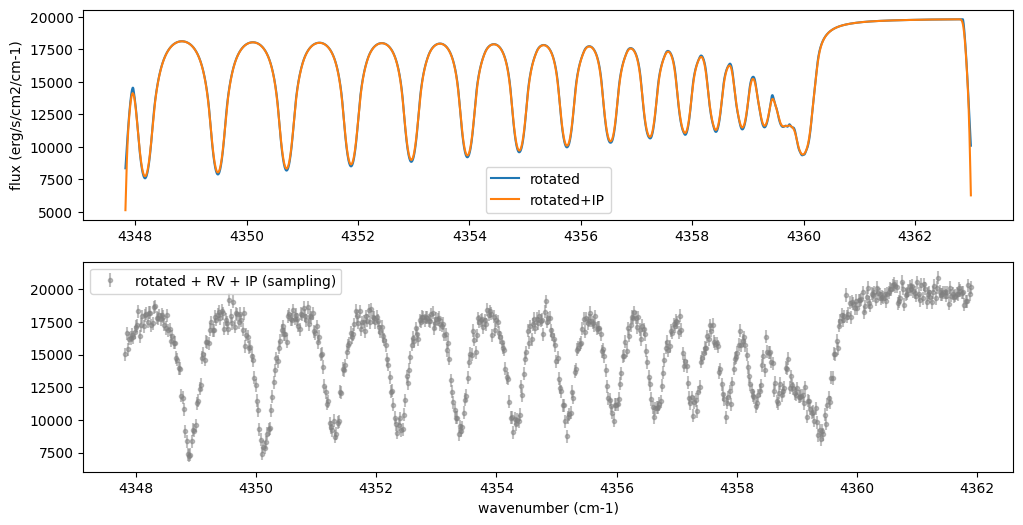

In [21]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
plt.plot(nu_grid, Frot, label="rotated")
plt.plot(nu_grid, Finst, label="rotated+IP")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.legend()
ax = fig.add_subplot(212)
plt.errorbar(nu_obs, Fobs, noise, fmt=".", label="rotated + RV + IP (sampling)", color="gray",alpha=0.5)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.show()

## 5. Retrieval of an Emission Spectrum

Next, let’s perform a “retrieval” on the simulated spectrum created above. Retrieval involves estimating the parameters of an atmospheric model in the form of a posterior distribution based on the spectrum. To do this, we first need a model. Here, we have compiled the forward modeling steps so far and defined the model as follows. The spectral model has six parameters.

In [22]:
def fspec(T0, alpha, mmr, g, RV, vsini):
    #molecule
    Tarr = art.powerlaw_temperature(T0, alpha)
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(mmr)
    dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opacia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtau + dtaucH2H2
    F = art.run(dtau, Tarr)
    Frot = sop_rot.rigid_rotation(F, vsini, u1, u2)
    Finst = sop_inst.ipgauss(Frot, beta_inst)
    mu = sop_inst.sampling(Finst, RV, nu_obs)
    return mu

Let’s verify that spectra are being generated from `fspec` with various parameter sets.

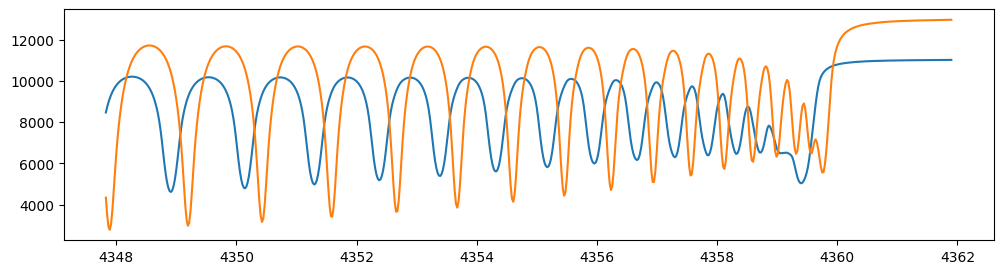

In [23]:
fig = plt.figure(figsize=(12, 3))

plt.plot(nu_obs, fspec(1200.0, 0.09, 0.01, gravity_jupiter(1.0, 1.0), 40.0, 10.0),label="model")
plt.plot(nu_obs, fspec(1100.0, 0.12, 0.01, gravity_jupiter(1.0, 10.0), 20.0, 5.0),label="model")

NumPyro is a probabilistic programming language (PPL), which requires the definition of a probabilistic model. In the probabilistic model `model_prob` defined below, the prior distributions of each parameter are specified. The previously defined spectral model is used within this probabilistic model as a function that provides the mean $\mu$. The spectrum is assumed to be generated according to a Gaussian distribution with this mean and a standard deviation $\sigma$. i.e. $f(\nu_i) \sim \mathcal{N}(\mu(\nu_i; {\bf p}), \sigma^2 I)$, where ${\bf p}$ is the spectral model parameter set, which are the arguments of `fspec`. 



In [24]:
import numpyro.distributions as dist
import numpyro
from jax import random



In [25]:
def model_prob(spectrum):

    #atmospheric/spectral model parameters priors
    logg = numpyro.sample('logg', dist.Uniform(4.0, 5.0))
    RV = numpyro.sample('RV', dist.Uniform(35.0, 45.0))
    mmr = numpyro.sample('MMR', dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(5.0, 15.0))
    mu = fspec(T0, alpha, mmr, 10**logg, RV, vsini)

    #noise model parameters priors
    sigmain = numpyro.sample('sigmain', dist.Exponential(1.e-3)) 
    numpyro.sample('spectrum', dist.Normal(mu, sigmain), obs=spectrum)

Here, we perform retrieval using [Stochastic Variational Inference (SVI)](https://num.pyro.ai/en/latest/svi.html) with NumPyro.

In [26]:
from numpyro.infer import SVI
from numpyro.infer import Trace_ELBO
import numpyro.optim as optim

In variational inference, inference is performed using a *guide distribution* that is computationally convenient. In many cases, designing this guide distribution is crucial, but for complex models, it can be time-consuming and challenging to find an optimal form.
While it is possible to manually define a guide distribution (approximate posterior) when performing variational inference (VI), here we will use [Automatic Guide Generation](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoBNAFNormal), which automatically generates an appropriate guide distribution based on the structure of the model.


### 5.1 Auto Guide using Multivariate Normal

First, let's try an example using a multivariate normal distribution.

In [27]:
from numpyro.infer.autoguide import AutoMultivariateNormal
guide = AutoMultivariateNormal(model_prob)
optimizer = optim.Adam(0.01)
svi = SVI(model_prob, guide, optimizer, loss=Trace_ELBO())

SVI is generally characterized by its lower computational cost compared to HMC-NUTS or nested sampling. The execution time below should be within one minute, or at most a few minutes.

In [28]:
num_steps = 2000
rng_key = random.PRNGKey(0)
rng_key, rng_key_run = random.split(rng_key)
svi_result = svi.run(rng_key_run, num_steps, spectrum=Fobs)

100%|██████████| 2000/2000 [00:18<00:00, 107.77it/s, init loss: 155873676511.3579, avg. loss [1901-2000]: 229592602.1244]


Let's use `Predictive` to generate spectrum predictions and check the results.

In [29]:
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import jax.numpy as jnp

In [30]:
params = svi_result.params
predictive = Predictive(
    model_prob,
    guide=guide,
    params=params,
    num_samples=2000,
    return_sites=("spectrum",),
)
predictions = predictive(rng_key, spectrum=None)
median_mu1 = jnp.median(predictions["spectrum"], axis=0)
hpdi_mu1 = hpdi(predictions["spectrum"], 0.9)

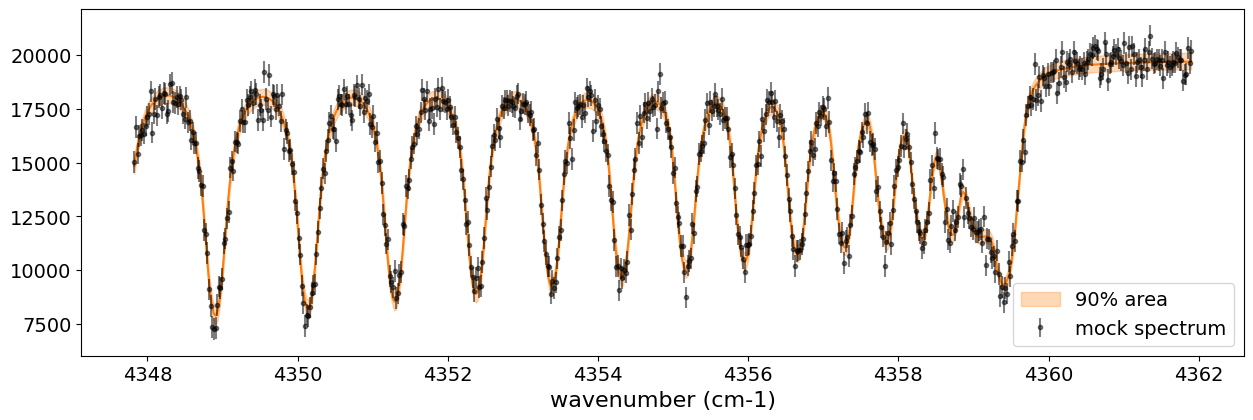

In [31]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(nu_obs, median_mu1, color='C1')
ax.fill_between(nu_obs,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(nu_obs, Fobs, noise, fmt=".", label="mock spectrum", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

To sample parameters, you need to set the `return_sites` argument in `Predictive`.

In [32]:
param_entries = ("logg", "RV", "MMR", "T0", "alpha", "vsini", "sigmain")
predictive_posterior = Predictive(
    model_prob,
    guide=guide,
    params=params,
    num_samples=2000,
    return_sites=param_entries,
)
posterior_sample = predictive_posterior(rng_key, spectrum=None)


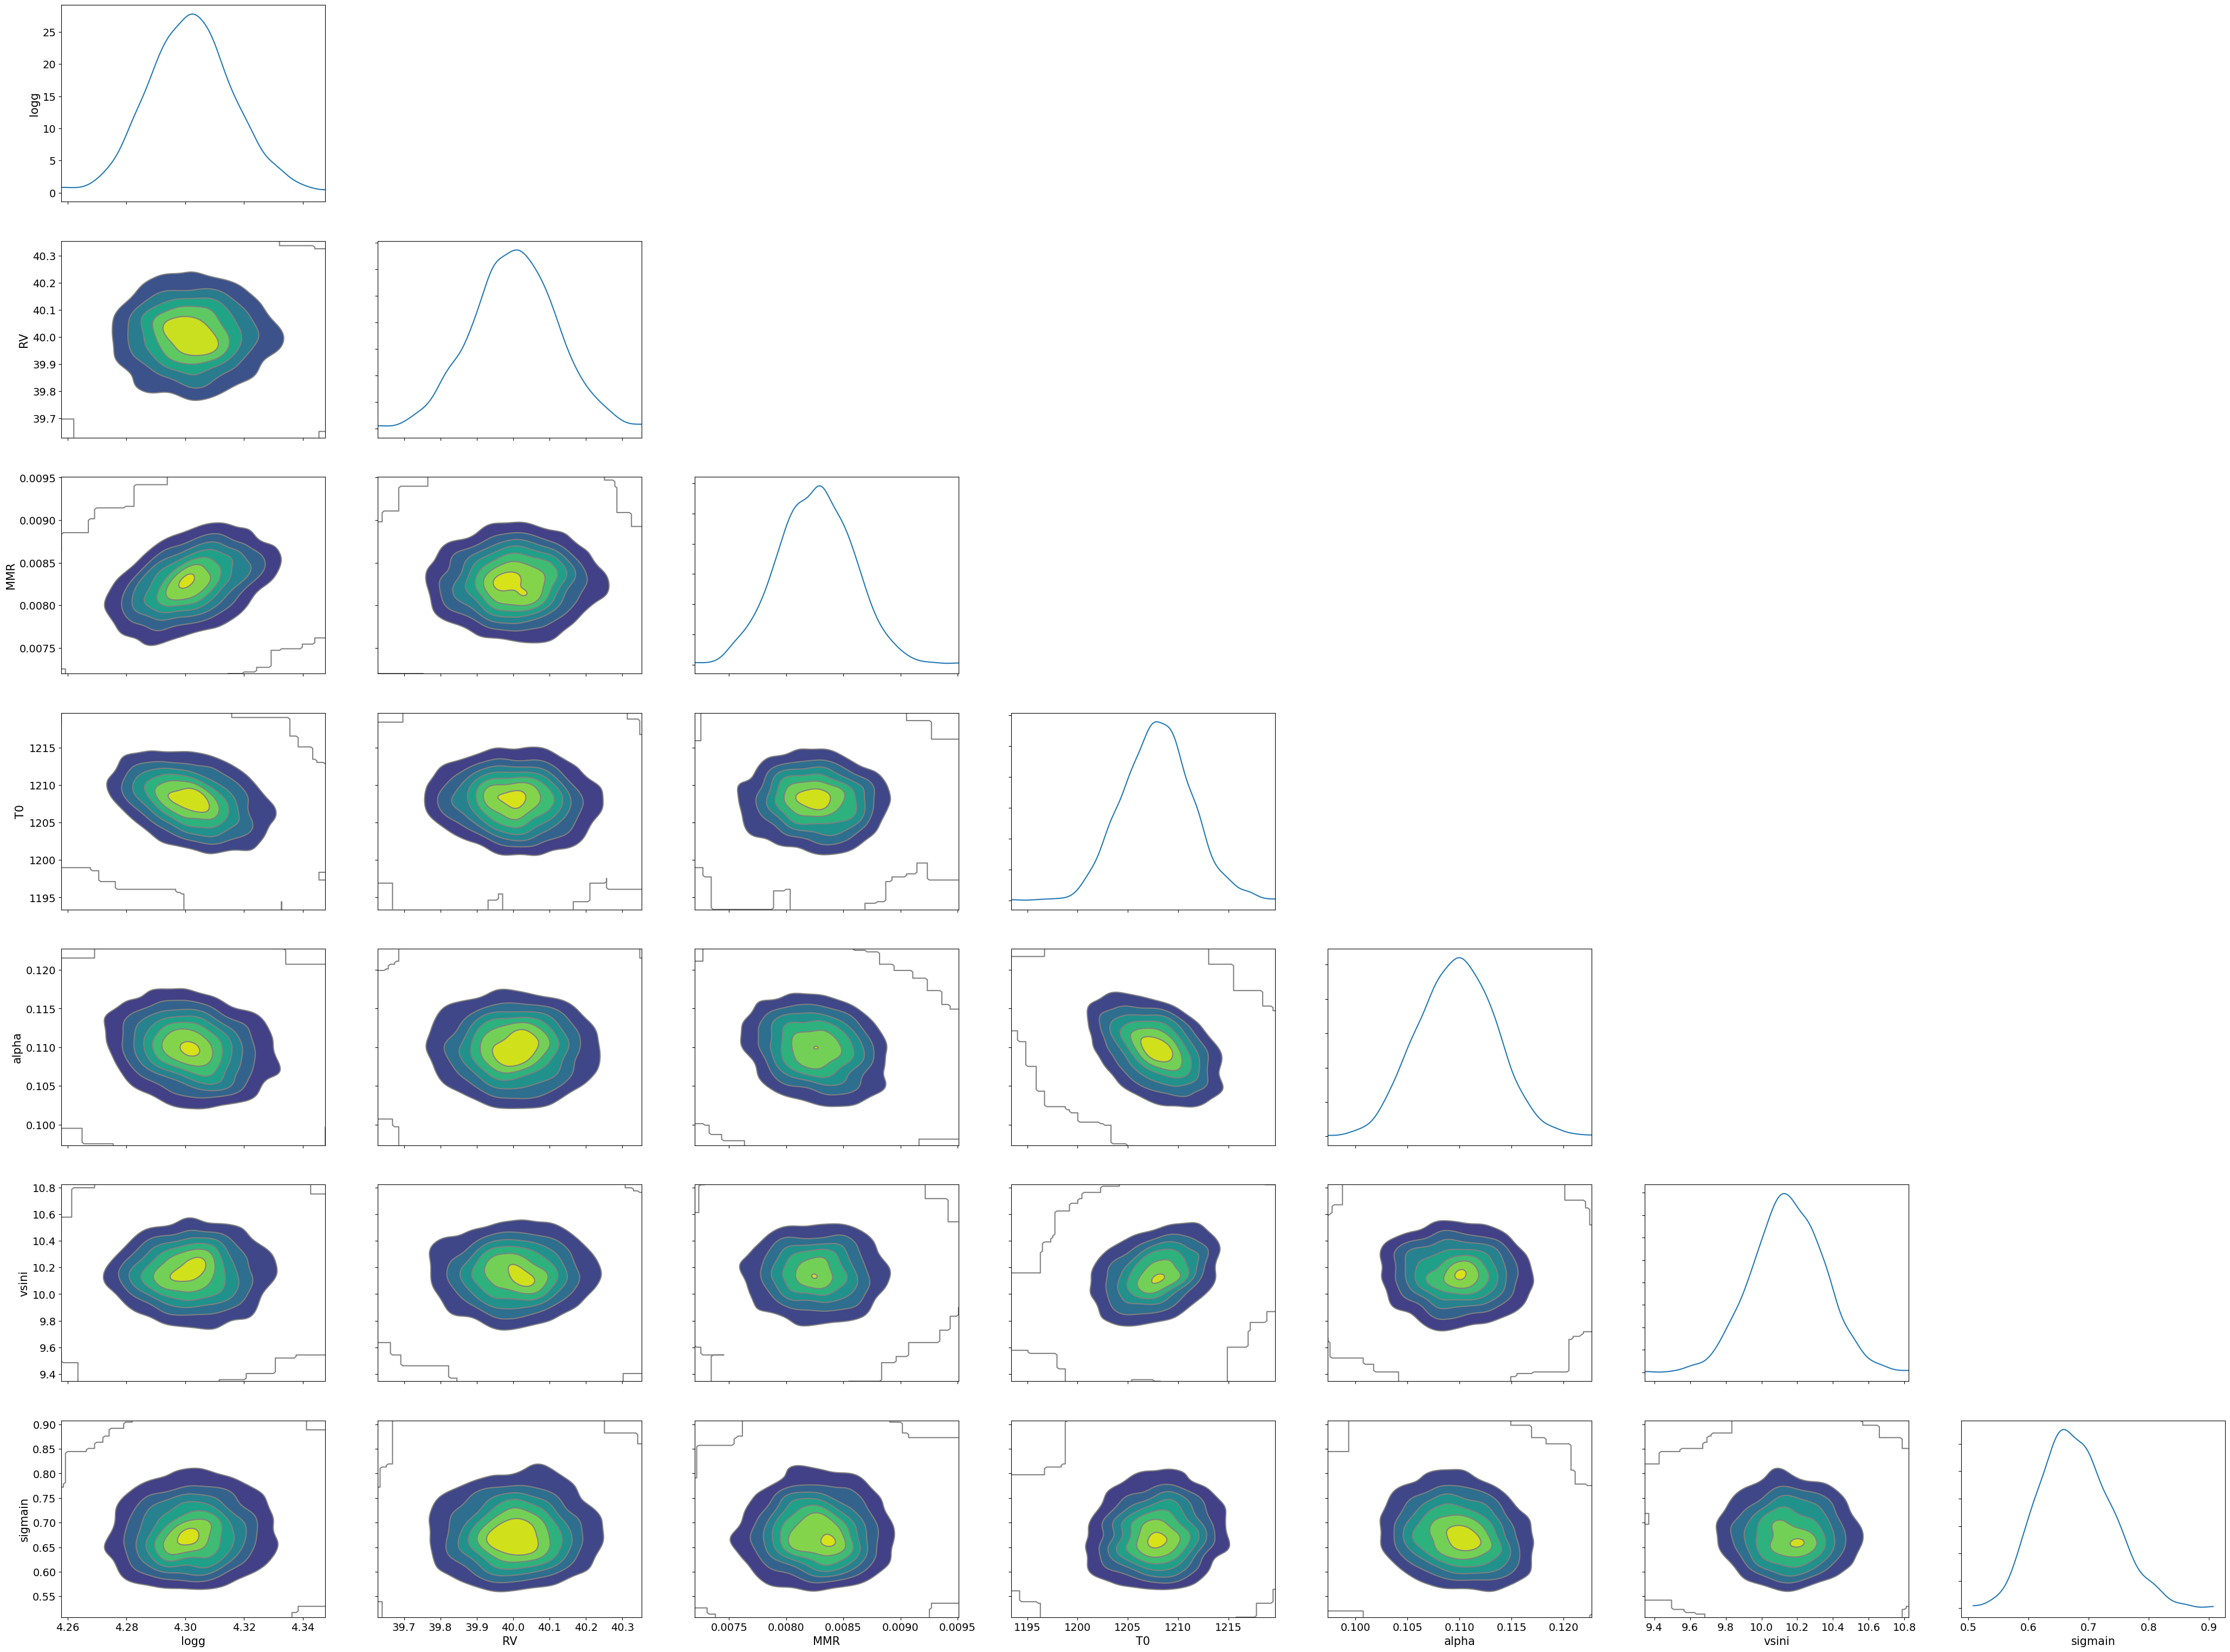

In [33]:
import arviz
idata = arviz.from_dict(posterior=posterior_sample)

arviz.plot_pair(
    idata,
    var_names=param_entries,
    kind="kde",
    marginals=True,
)
plt.show()

### 5.2 Auto Guide for BNAF

As another example, let's try `AutoBNAFNormal`, which utilizes Block Neural Autoregressive Flow (BNAF) within the framework of normalizing flows, a class of invertible transformations using neural networks. This method is more flexible than standard mean-field approximations, allowing it to capture high-dimensional and complex dependencies between latent variables.

In [34]:
from numpyro.infer.autoguide import AutoBNAFNormal
guide = AutoBNAFNormal(model_prob)
optimizer = optim.Adam(0.01)
svi = SVI(model_prob, guide, optimizer, loss=Trace_ELBO())

In [35]:
num_steps = 10000
rng_key = random.PRNGKey(0)
rng_key, rng_key_run = random.split(rng_key)
svi_result = svi.run(rng_key_run, num_steps, spectrum=Fobs)

100%|██████████| 10000/10000 [01:10<00:00, 142.20it/s, init loss: 2630039212.8949, avg. loss [9501-10000]: 6351.8862]


In [36]:
params = svi_result.params
predictive = Predictive(
    model_prob,
    guide=guide,
    params=params,
    num_samples=2000,
    return_sites=("spectrum",),
)
predictions = predictive(rng_key, spectrum=None)
median_mu1 = jnp.median(predictions["spectrum"], axis=0)
hpdi_mu1 = hpdi(predictions["spectrum"], 0.9)

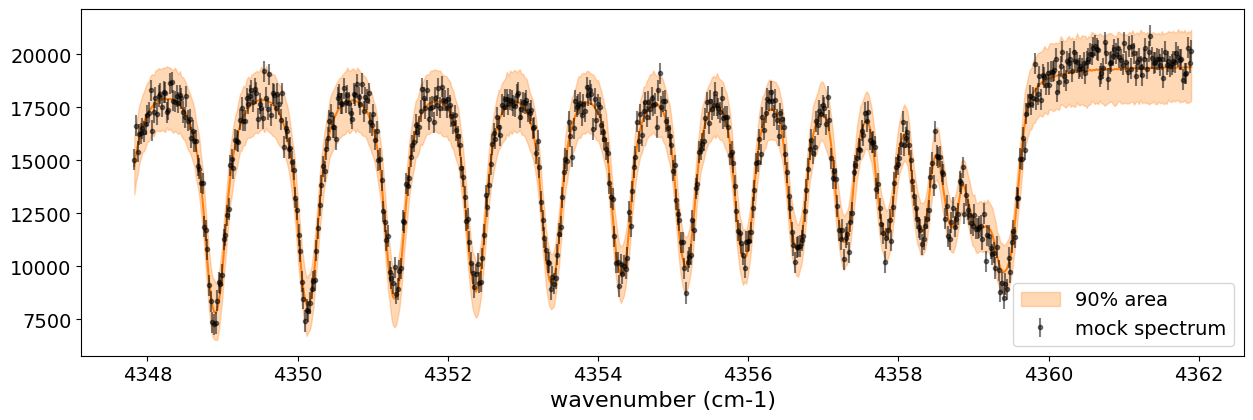

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(nu_obs, median_mu1, color='C1')
ax.fill_between(nu_obs,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(nu_obs, Fobs, noise, fmt=".", label="mock spectrum", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

In [38]:
predictive_posterior = Predictive(
    model_prob,
    guide=guide,
    params=params,
    num_samples=2000,
    return_sites=param_entries,
)
posterior_sample = predictive_posterior(rng_key, spectrum=None)


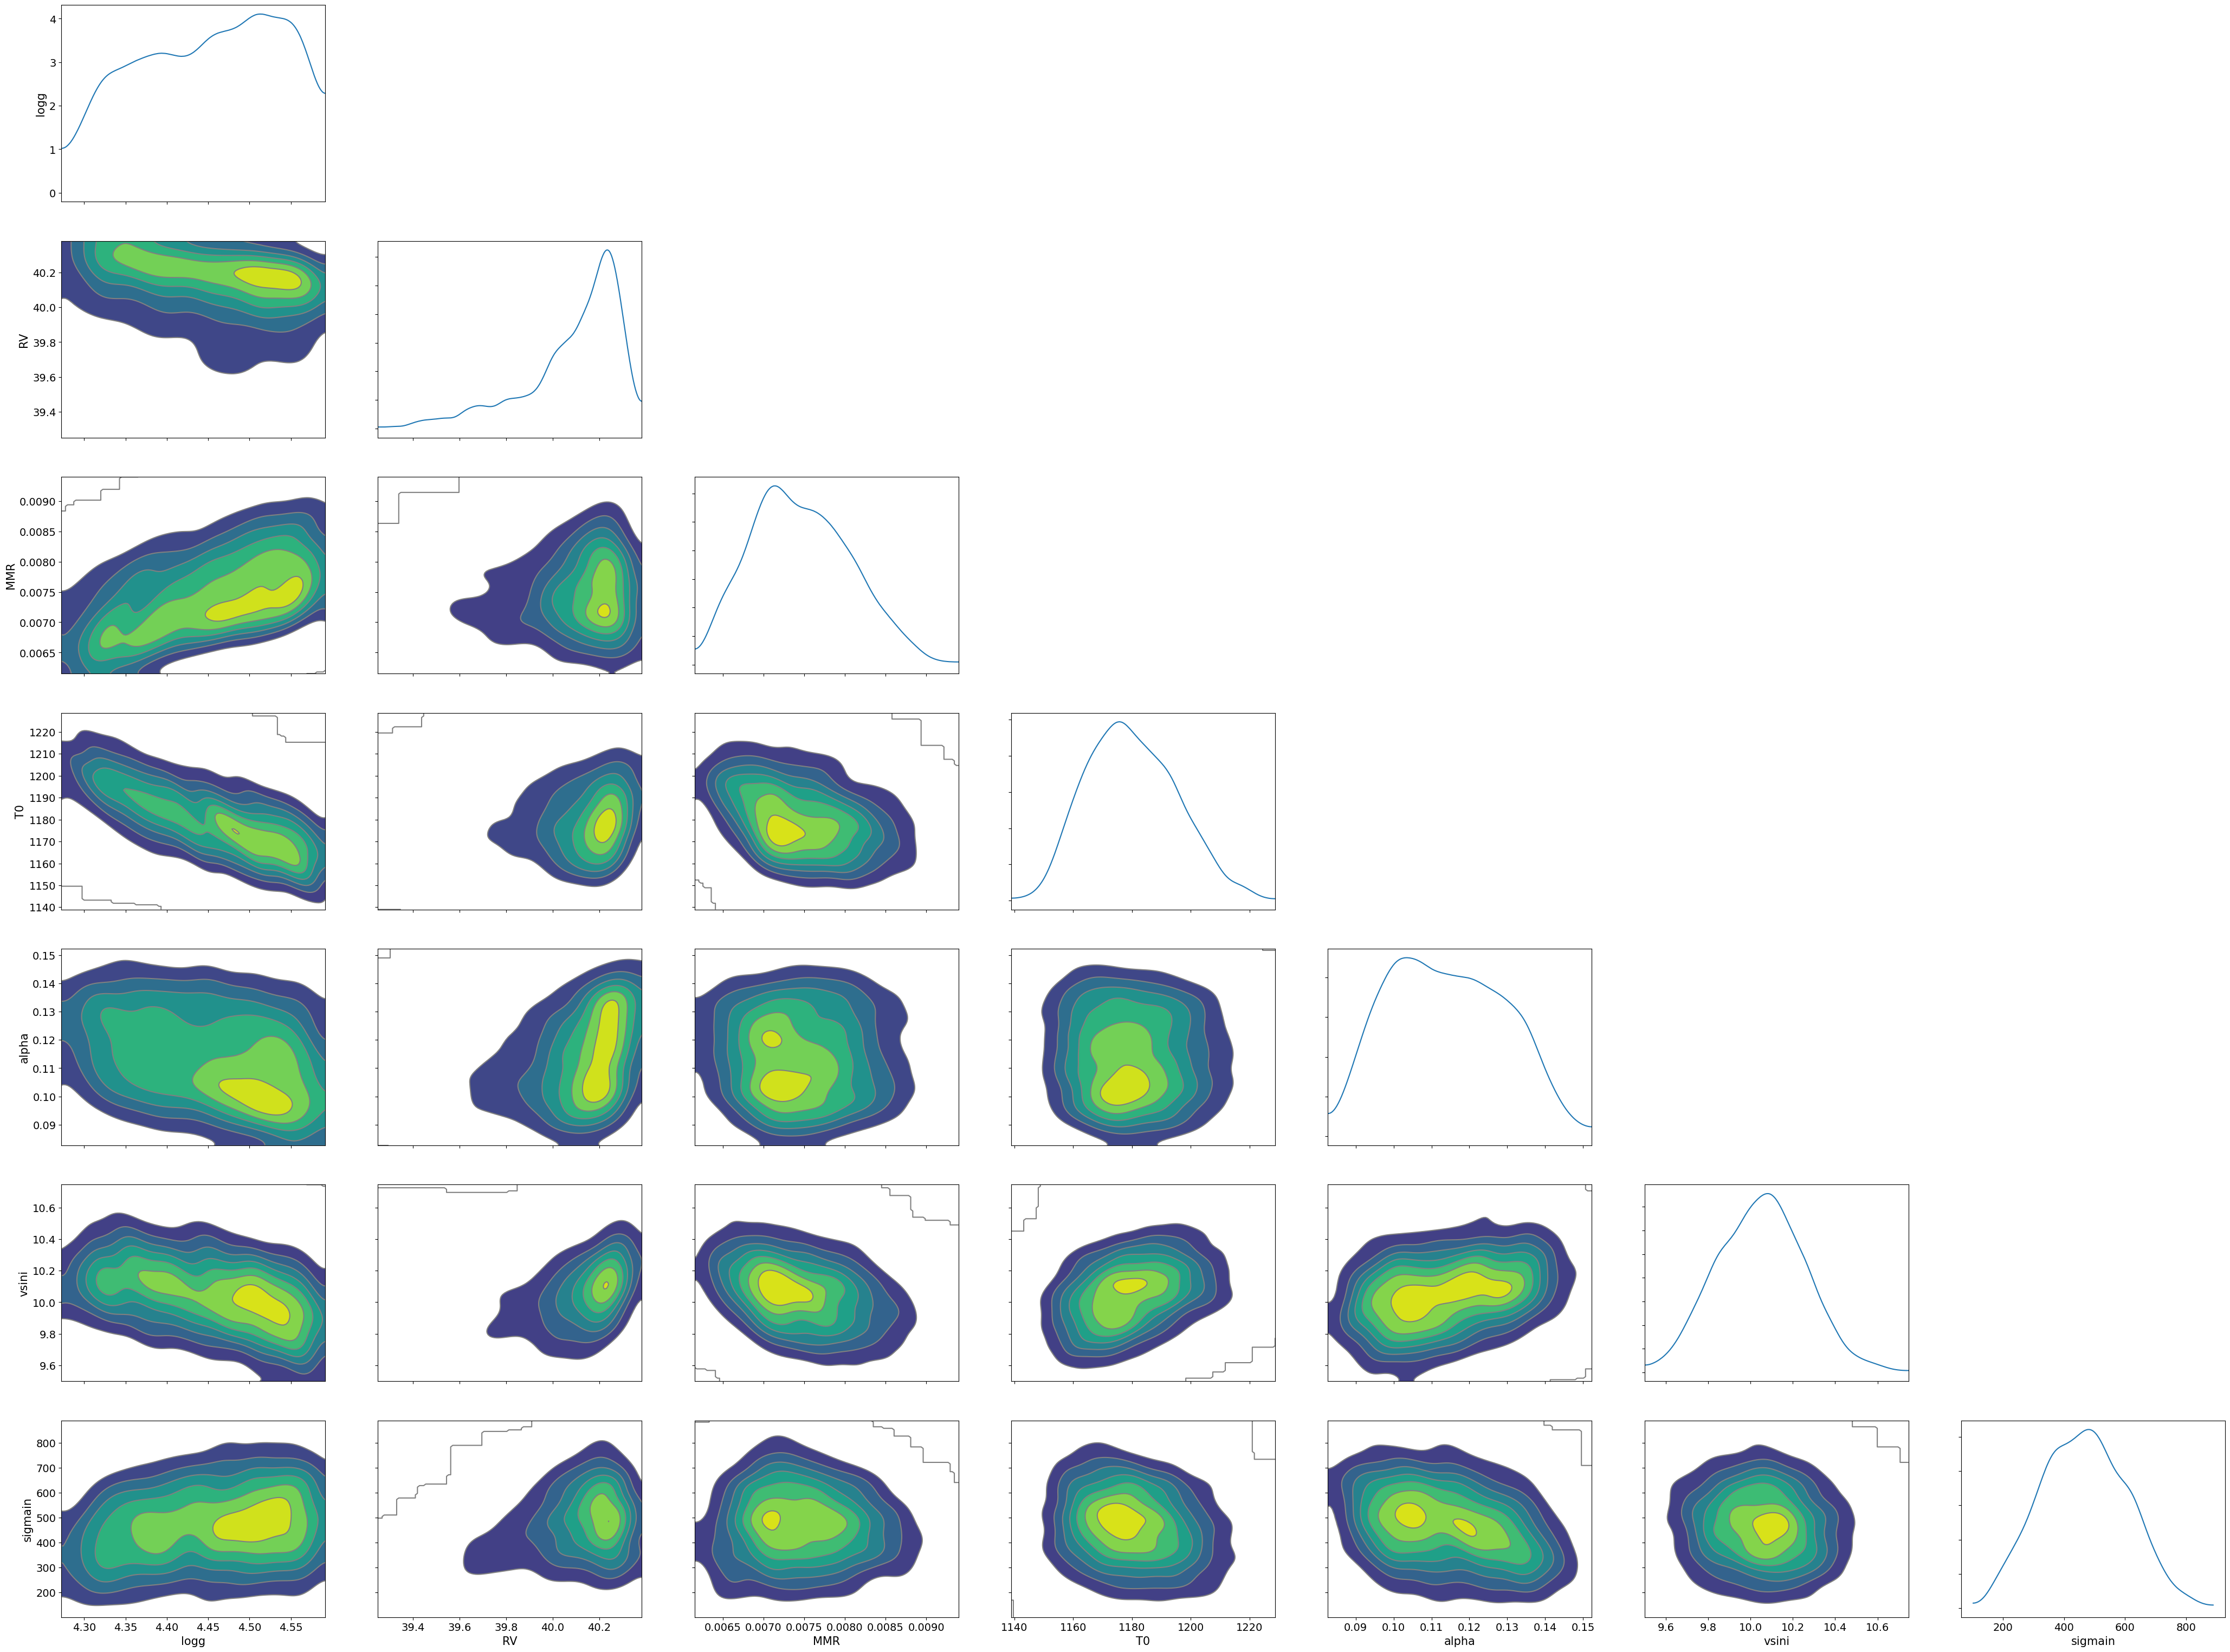

In [39]:
import arviz
idata = arviz.from_dict(posterior=posterior_sample)

arviz.plot_pair(
    idata,
    var_names=param_entries,
    kind="kde",
    marginals=True,
)
plt.show()

Various other [Automatic Guide Generation](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoBNAFNormal), are also available, so explore them.

That's it!